In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='Times New Roman')
plt.rcParams["mathtext.fontset"] = 'stix'

#width = 3.37 or 6.69 eps are preferred

In [191]:
import tike
import xdesign

mura = xdesign.mura_2d(64)
probe_mura = np.pad(mura, len(mura), 'constant')
probe_gauss = np.pad(tike.ptycho.gaussian(len(mura)), len(mura), 'constant')

MURA is length 61


In [204]:
#########|#########|#########|#########|#########|#########|#########|#########|

import matplotlib.gridspec as gridspec

def fig_illumination_compare(probes, labels):
    """"""
    plt.figure(figsize=(3.37, 3.37 / 2 * 2.5), dpi=200)

    nrows = 3
    ncols = len(probes)
    gs = gridspec.GridSpec(nrows, ncols)
    gs.update(left=0.17, right=1., bottom=0.05, top=1.)
    
    linestyles = ['-', '--']

    for i, probe in enumerate(probes):        
        # draw the probe
        plt.subplot(gs[0, i])
        plt.imshow(probe)
        if i == 0:
            plt.ylabel('illumination')
        # draw the FFT
        plt.subplot(gs[1, i])
        amplitude = np.abs(np.fft.fftshift(np.fft.fft2(probe)))
        plt.imshow(amplitude)
        if i == 0:
            plt.ylabel('far-field amplitude')
        # draw line through probe
#         plt.subplot(gs[1, :])
#         plt.plot(probe[probe.shape[0]//2,:])
        # draw line through FFT
        plt.subplot(gs[2, :])
        plt.semilogy(amplitude[amplitude.shape[0]//2,:], linestyles[i], linewidth=1)
        plt.legend(labels, ncol=2)
        plt.ylabel('log(far-field amplitude)')

    plt.savefig("./figures/FFT_compare.pdf", dpi=600)
    plt.show()

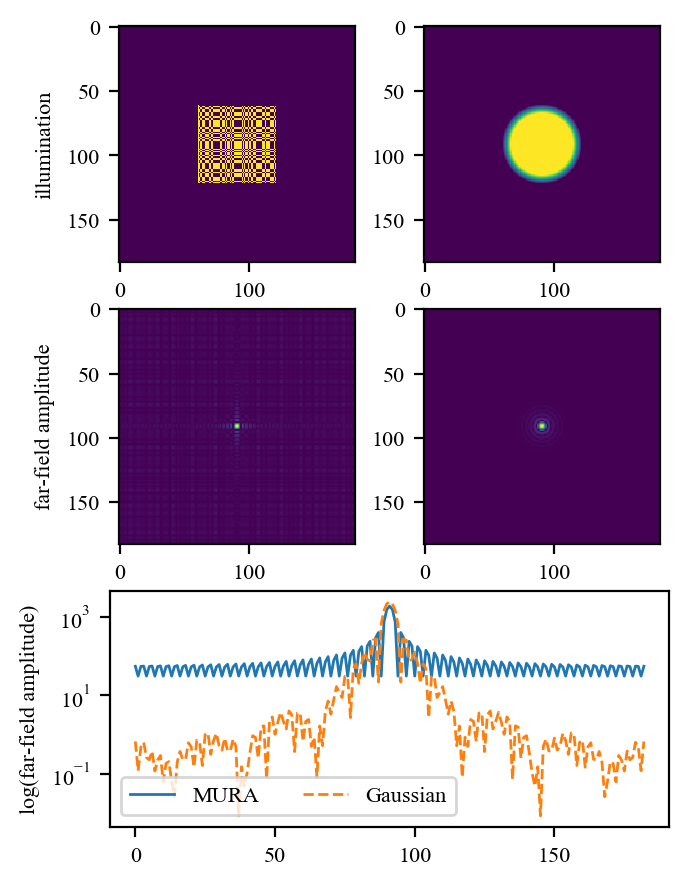

In [205]:
fig_illumination_compare([probe_mura, probe_gauss], labels=['MURA', 'Gaussian'])